This is a python tool for segmentation of ROIs in a 57K mask. Each superspot is segmented, and the ROIs within each of those are extracted. 

The ROIs are represented as a dictionary of segmentation masks, key representing superspot number, value representing a 2D array of similar format used in pipeline code (each ROI represented by a distinct pixel value, ROI pixel values increment by 1 from one ROI to another). 

In theory, this dictionary would be fed to rest of pipeline, which would run downstream image analysis on each of the superspot mask arrays. 

Total time to run is < 1 minute

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pylab import array, plot, show, axis, arange, figure, uint8 
import pandas as pd

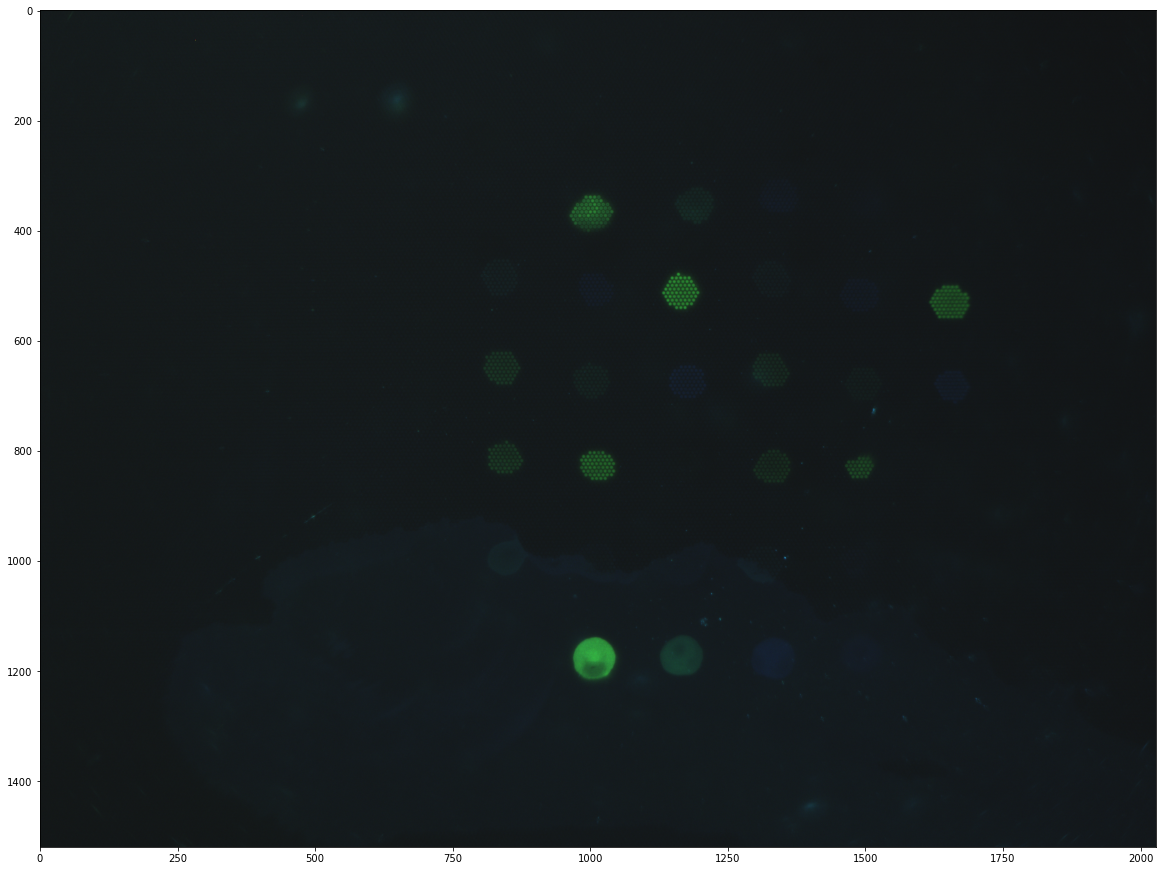

In [2]:
image = cv2.imread('/Users/akshi/Downloads/57.tif', cv2.IMREAD_COLOR)  # load as 3-channel BGR image
plt.figure(figsize=(20,20))
plt.imshow(image)

In [3]:
# Assuming grayhighlow is a 3-channel BGR image, convert it to grayscale
grayhighlow = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Thresholding to create a binary image with black and white
ret, binary_image = cv2.threshold(grayhighlow, 28, 255, cv2.THRESH_BINARY)

# Apply a Gaussian blur to find the superspots
blur = cv2.GaussianBlur(binary_image,(15,15),cv2.BORDER_DEFAULT)

# Threshold the blurred image to BW
ret, binary_image_blurred = cv2.threshold(blur, 30, 255, cv2.THRESH_BINARY)

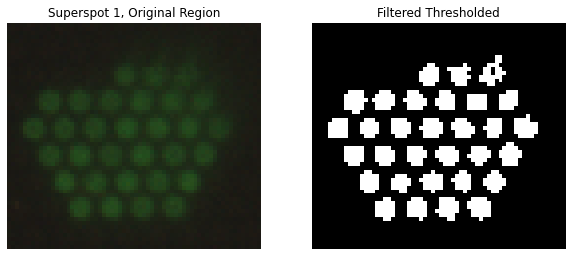

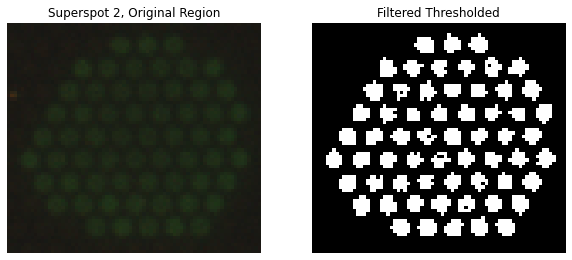

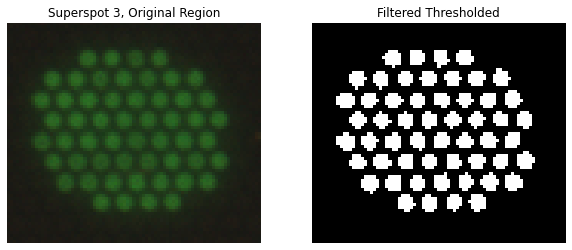

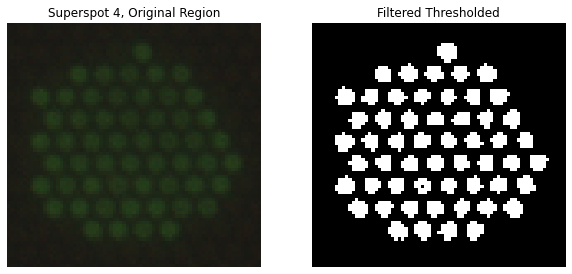

5


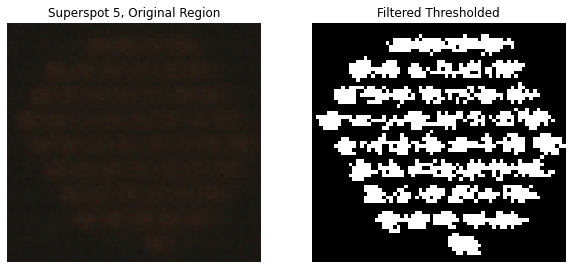

6


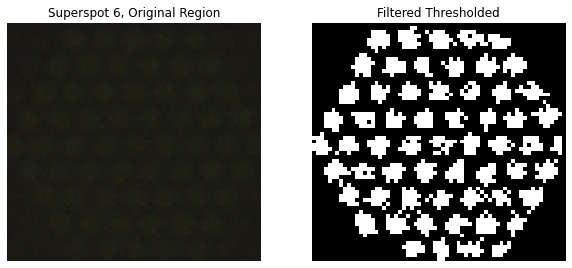

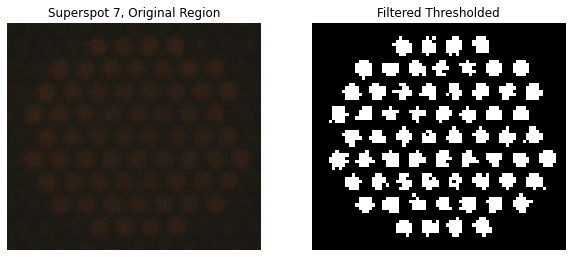

8


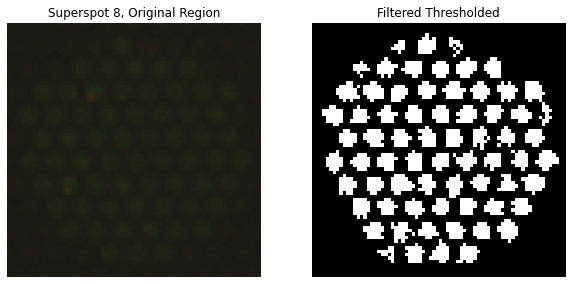

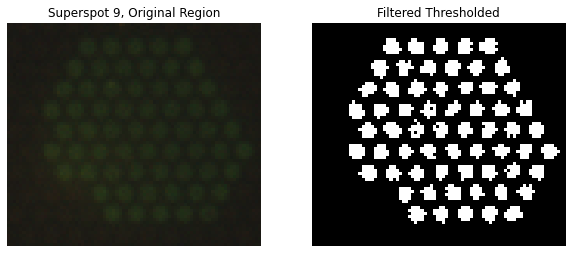

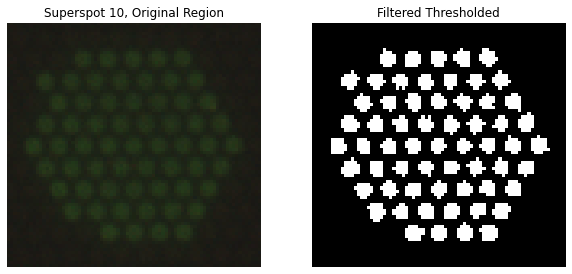

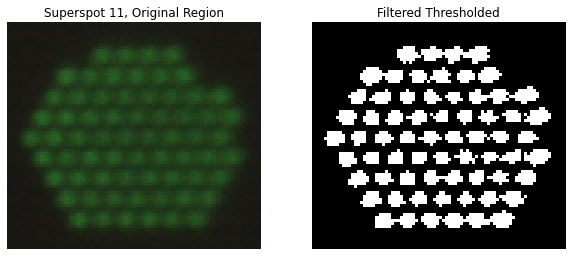

12


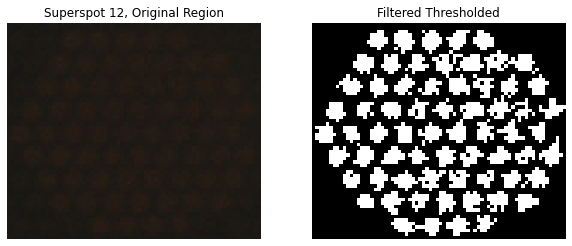

13


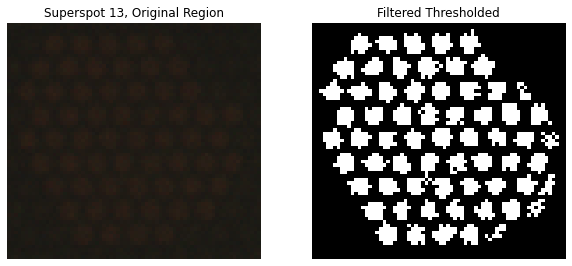

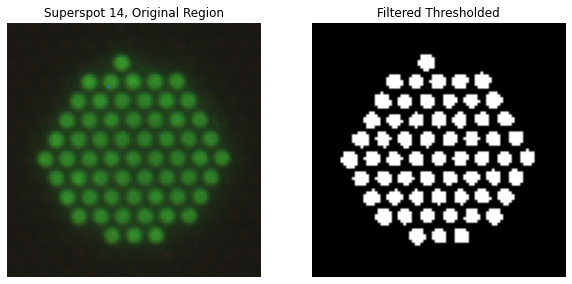

15


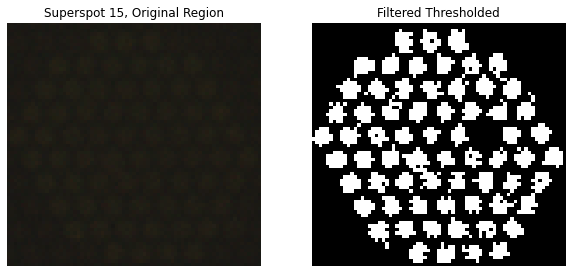

16


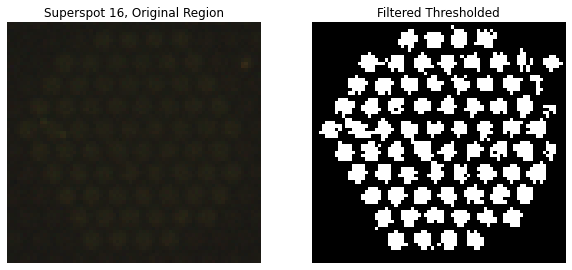

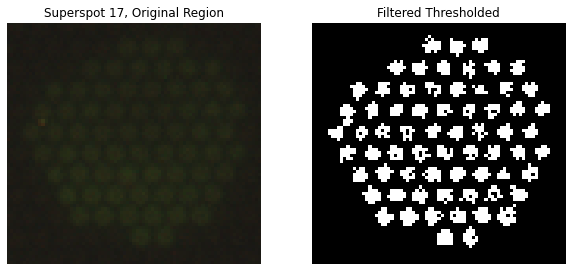

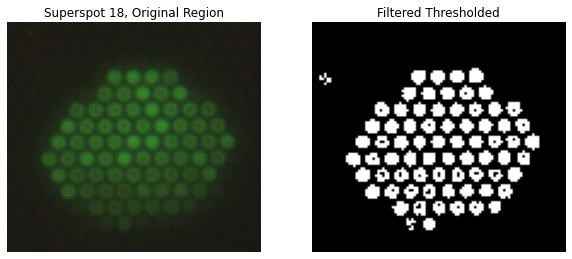

19


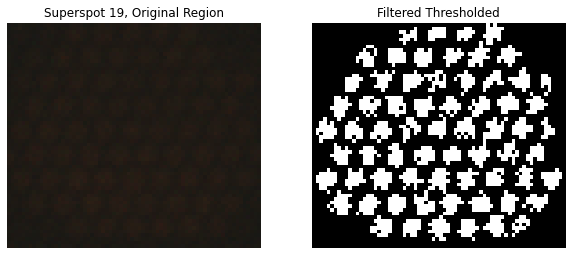

In [4]:
min_area_threshold = 2000  # Adjust as needed
max_area_threshold = 100000  # Adjust as needed

min_component_size = 10  # Adjust as needed to remove small regions
min_circularity = 0  # Adjust as needed to keep only very circular components

# Define the contrast control parameter (alpha) and brightness control parameter (beta)
alpha = 1  # Increase contrast (you can adjust this value as needed)
beta = 1    # No brightness adjustment (you can adjust this value as needed)

#Dictionary mapping super spot to its mask
super_spot_sam_masks = {}

def is_contour_circular(contour):
    # Function to determine if a contour is circular based on its area and perimeter
    perimeter = cv2.arcLength(contour, True)
    area = cv2.contourArea(contour)
    circularity = 4 * np.pi * area / (perimeter * perimeter)
    return circularity > 0.6  # Adjust the threshold for circularity as needed

def process_binary_image(binary_image, original_image):
    global alpha
    global beta
    
    final_contours = []
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a new black image with the same size as the original image
    result_image = np.zeros_like(binary_image)    

    # Create a mask to hold the selected circular regions
    super_spot_mask = np.zeros_like(binary_image)
    
    curr_super_spot = 0
    
    # Create a blank image to hold the labels
    label_image = np.zeros_like(original_image)
    
    # Create pixel intensity table
    df_data = []
    
    # Iterate through the contours and filter based on size and circularity
    for idx, contour in enumerate(contours):  # Added 'idx' to get the region number        
        if cv2.contourArea(contour) > min_area_threshold and cv2.contourArea(contour) < max_area_threshold and is_contour_circular(contour):
            final_contours.append(contour)
            curr_super_spot += 1

            # Fill the contour in the mask
            cv2.drawContours(super_spot_mask, [contour], -1, 255, cv2.FILLED)

            # Get the bounding rectangle of the contour
            x, y, w, h = cv2.boundingRect(contour)

            # Get the region from the original image corresponding to the contour
            region = original_image[y:y+h, x:x+w]
            
            total_intensity = np.sum(region)
            total_pixels = region.size
            intensity = total_intensity / total_pixels         
            
            df_data.append({'Superspot': curr_super_spot, 'Total Intensity': intensity})
            
            if (intensity < 27):
                print(curr_super_spot)
                alpha = 5

            # Convert the region to grayscale
            gray_region = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY)
            gray_region = cv2.convertScaleAbs(gray_region, alpha=alpha, beta=beta)
            
            alpha = 1

            # Create a mask of the same size as the region
            contour_mask = np.zeros_like(gray_region)

            # Draw the contour on the mask
            cv2.drawContours(contour_mask, [contour - (x, y)], -1, 255, cv2.FILLED)

            # Apply the adaptive threshold only within the contour using the mask
            adaptive_thresholded = cv2.adaptiveThreshold(gray_region, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, -1)
            adaptive_thresholded[contour_mask == 0] = 0
            
            # Label connected components in the thresholded image
            num_labels, labeled_image, stats, _ = cv2.connectedComponentsWithStats(adaptive_thresholded)
                        
            # Remove small regions based on the minimum component size and circularity threshold
            num_filtered_components = 0  # Variable to count the number of found contours in the region
            for label in range(1, num_labels):
                if stats[label, cv2.CC_STAT_AREA] < min_component_size:
                    labeled_image[labeled_image == label] = 0
                else:
                    contour_points = np.argwhere(labeled_image == label)
                    area = stats[label, cv2.CC_STAT_AREA]
                    perimeter = 2 * (stats[label, cv2.CC_STAT_WIDTH] + stats[label, cv2.CC_STAT_HEIGHT])
                    circularity = 4 * np.pi * area / (perimeter * perimeter)
                    if circularity < min_circularity:
                        labeled_image[contour_points[:, 0], contour_points[:, 1]] = 0
                                                
            labeled_image = labeled_image.astype(np.uint8)
            num_labels, cumulative_labeled_image, stats, _ = cv2.connectedComponentsWithStats(labeled_image)
            
            super_spot_sam_masks[curr_super_spot] = cumulative_labeled_image
                                    
            # Create a mask for the filtered region
            mask = np.zeros_like(gray_region)
            mask[labeled_image != 0] = curr_super_spot
            
            # Draw the filtered region on the result image using the same color
            result_image[y:y+h, x:x+w][cumulative_labeled_image != 0] = curr_super_spot

            # Label each super spot in the label_image
            text_position = (x + 5, y + 20)  # Adjust the position of the text
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 1
            font_color = (255, 0, 0)  # White color
            line_type = 4
            cv2.putText(label_image, str(curr_super_spot), text_position, font, font_scale, font_color, line_type)
                        
            # Create a new figure for each region
            plt.figure(figsize=(10, 5))

            # Plot the original region
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
            plt.title("Superspot " + str(curr_super_spot) + ", Original Region")
            plt.axis("off")

            # Plot the filtered thresholded result
            plt.subplot(1, 2, 2)
            plt.imshow(mask, cmap='gray')
            plt.title(f"Filtered Thresholded")
            plt.axis("off")

            # Show the figure for this region
            plt.show()
            
    df = pd.DataFrame(df_data)

    return result_image, super_spot_mask, final_contours, super_spot_sam_masks, label_image, df

# Assuming you have already thresholded and blurred the image
# You can set the minimum and maximum area thresholds to suit your requirements
min_area_threshold = 2000  # Adjust as needed
max_area_threshold = 100000  # Adjust as needed

# Process the binary image and display each region's computed thresholded region as an individual figure
result_image, super_spot_mask, final_contours, super_spot_sam_masks, label_image, df = process_binary_image(binary_image_blurred, image)

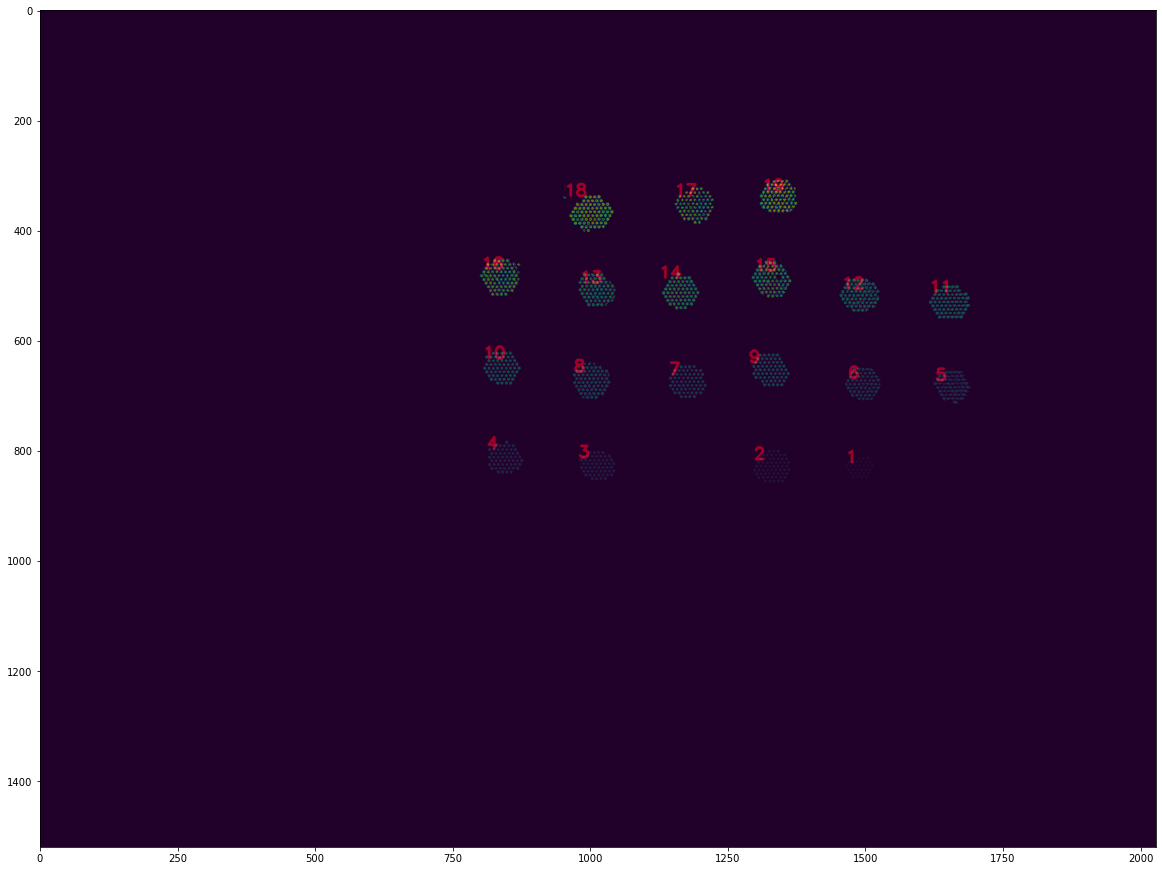

In [5]:
plt.figure(figsize=(20,20))
plt.imshow(label_image)
plt.imshow(result_image, alpha=0.5)
plt.show()

In [6]:
super_spot_sam_masks

{1: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 2: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 3: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 4: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 5: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 